In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import statsmodels.graphics as smg
import seaborn as sns

# Import and Clean Data

In [2]:
file_path = "/Users/nicholasoxenden/Oxenden/ECON 388/388 Paper/388 Research Data/IPUMS/usa_00006.dta"

df = pd.read_stata(file_path)

sample_df = df.copy()

In [3]:
### Clean sample_df

sample_df.drop(['raced','educd','empstatd'],axis=1,inplace=True)

### Drop Unemployed Individuals

sample_df = sample_df[sample_df['empstat'] == 'employed']

### Drop Individuals with no income

sample_df = sample_df[sample_df.incwage != (999999)]
sample_df = sample_df[sample_df.incwage != (999998)]
sample_df = sample_df[sample_df.incwage != (0)]

### Clean Age and Define Agesq

sample_df = sample_df[sample_df.age != '90 (90+ in 1980 and 1990)']

sample_df['age'] = sample_df['age'].astype(float)

sample_df = sample_df[(sample_df['age'] >= 18) & (sample_df['age'] <= 65)]

sample_df['agesq'] = (sample_df['age'] ** 2)

In [4]:
### Define Nchild Dummies
#sample_df = pd.get_dummies(data=sample_df,columns=['nchild'])


### Define nchild and nchild2 columns
sample_df = sample_df[sample_df['nchild'] != '9+']

nchild_categories = ['0 children present', '1 child present','2','3','4','5','6','7','8']
nchild_values = [0,1,2,3,4,5,6,7,8]

for i in range(0,len(nchild_values)):
    sample_df['nchild'] = [nchild_values[i] if x == nchild_categories[i] else x for x in sample_df['nchild']]

sample_df['nchildsq'] = (sample_df['nchild'] ** 2)

In [5]:
### Define Marst Dummies
#sample_df = pd.get_dummies(data=sample_df,columns=['marst'])

married_categories = [['married, spouse present','married, spouse absent'],['separated','divorced','widowed','never married/single']]
married_variables = ['married','unmarried']

for i in range(0,len(married_categories)):
    sample_df[married_variables[i]] = [1 if x in married_categories[i] else 0 for x in sample_df['marst']]

In [6]:
## Define Gender Dummies
gender_variables = ['male','female']

for i in range(0,len(gender_variables)):
    sample_df[gender_variables[i]] = [1 if x == gender_variables[i] else 0 for x in sample_df['sex']]

In [7]:
### Define Industry Dummies
industry_variables = ['ag_frst', 'mine_oil_gas','constr','manufac','wholesale_trade','retail_trade','transport_warehouse','utilities','information','fin_ins','real_est','profess_scientific','management','admin_wastemngmnt','educ_serv','health','ent_rec','food_serv','other_ind','public_admin','mil','unemp_ind']
industry_codes = [(170,290),(370,490),(770,770),(1070,3990),(4070,4590),(4670,5790),(6070,6390),(570,690),(6470,6780),(6870,6992),(7071,7190),(7270,7490),(7570,7570),(7580,7790),(7860,7890),(7970,8470),(8561,8590),(8660,8690),(8770,9290),(9370,9590),(9670,9870),(9920,9920)]


for i in range(0,len(industry_variables)):
    sample_df[industry_variables[i]] = [1 if x in range(industry_codes[i][0],industry_codes[i][1] + 1) else 0 for x in sample_df['ind']]

In [8]:
### Define Race Dummies
race_categories = ['white',['black/african american/negro'],['other asian or pacific islander','chinese','japanese'],['other race, nec','american indian or alaska native','two major races']]
race_variables = ['white', 'black','asian','other_race']

for i in range(0,len(race_categories)):
    sample_df[race_variables[i]] = [1 if x in race_categories[i] else 0 for x in sample_df['race']]

In [9]:
### Define Education Dummies

education_categories = [['n/a or no schooling'],['nursery school to grade 4','grade 5, 6, 7, or 8'],['grade 9','grade 10','grade 11','grade 12'],['1 year of college','2 years of college','3 years of college'],['4 years of college'],['5+ years of college']]
education_variables = ['no_schooling','elementary_educ','hs_educ','partial_college','college_degree','grad_educ']

for i in range(0,len(education_categories)):
    sample_df[education_variables[i]] = [1 if x in education_categories[i] else 0 for x in sample_df['educ']]

# Prep for Regression

In [10]:
dummy_df = sample_df.copy()

vis_df = dummy_df.copy()

reg_df = dummy_df.copy()


# Regress

In [11]:
reg_df['lnincwage'] = reg_df['incwage'].apply(np.log)

reg_df.drop(['incwage','year','race','educ','ind','sex','empstat','marst','unemp_ind'],axis=1,inplace=True)

reg_df.dropna(inplace=True)

In [12]:
base_group = ['white','male','fin_ins','college_degree','married']

drop_cols = base_group + ['lnincwage']

regression_cols = []
for i in reg_df.columns:
    if i in drop_cols:
        pass
    else:
        regression_cols.append(i)

In [13]:
y = reg_df['lnincwage'].to_numpy()

X = sm.add_constant(reg_df[regression_cols].to_numpy())

In [14]:
model = sm.OLS(y,X)
results = model.fit()

print(results.get_robustcov_results(cov_type = 'HC1').summary(xname=['const'] + regression_cols,yname='lnincwage'))

                            OLS Regression Results                            
Dep. Variable:              lnincwage   R-squared:                       0.371
Model:                            OLS   Adj. R-squared:                  0.371
Method:                 Least Squares   F-statistic:                     9990.
Date:                Mon, 07 Jun 2021   Prob (F-statistic):               0.00
Time:                        17:20:54   Log-Likelihood:            -8.5585e+05
No. Observations:              671456   AIC:                         1.712e+06
Df Residuals:                  671421   BIC:                         1.712e+06
Df Model:                          34                                         
Covariance Type:                  HC1                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   8.4438    

Shapiro Test
stat: 0.9129465818405151
p: 0.0

Normal Test
stat: 214253.13563584158
p: 0.0


/Users/nicholasoxenden/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


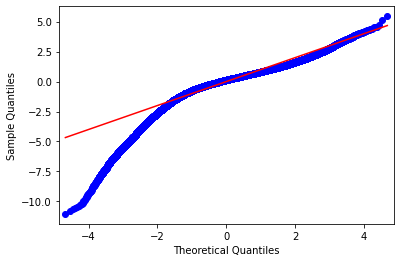

In [15]:
### Test Residuals for Normality
print("Shapiro Test")
stat, p = st.shapiro(results.resid)
print(f"stat: {stat}")
print(f"p: {p}")
print("")
print("Normal Test")
stat, p = st.normaltest(results.resid)
print(f"stat: {stat}")
print(f"p: {p}")

fig = smg.gofplots.qqplot(results.resid, st.norm, fit=True, line="s")
plt.show()

In [16]:
### BP test for heteroskedasticity
sm.stats.diagnostic.het_breuschpagan(results.resid,X)

(7983.944810087751, 0.0, 237.63526713045295, 0.0)

# Visualize the Data

In [17]:
vis_df = sample_df[sample_df['fin_ins'] == 1]

vis_df.loc[:,'lnincwage'] = vis_df.loc[:,'incwage'].apply(np.log)

/Users/nicholasoxenden/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/nicholasoxenden/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


[None, None]

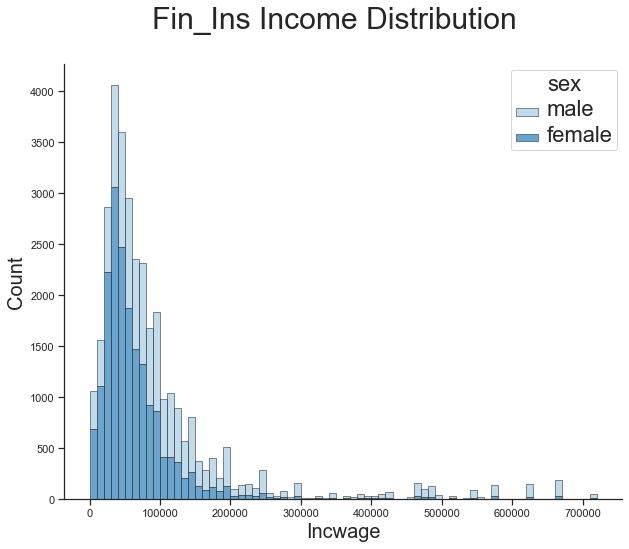

In [18]:
sns.set_theme(style="ticks")

f, ax = plt.subplots(figsize=(10, 8))
sns.despine(f)

sns.histplot(
    vis_df,
    x="incwage", hue="sex",
    multiple="stack",
    palette="Blues",
    edgecolor=".1",binwidth=10000,
    linewidth=.5,
    log_scale=False,
)


f.suptitle('Fin_Ins Income Distribution', fontsize=30)
ax.set_xlabel('Incwage', fontsize=20)
ax.set_ylabel('Count', fontsize=20)

plt.setp(ax.get_legend().get_texts(), fontsize='22') 
plt.setp(ax.get_legend().get_title(), fontsize='22')

# plt.ylim(0, 5000)
# plt.xlim(0, None)

[None, None]

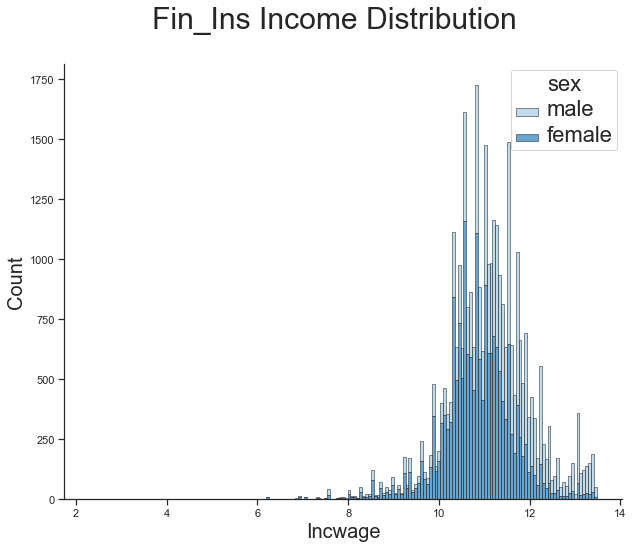

In [19]:
sns.set_theme(style="ticks")

f, ax = plt.subplots(figsize=(10, 8))
sns.despine(f)

sns.histplot(
    vis_df,
    x="lnincwage", hue="sex",
    multiple="stack",
    palette="Blues",
    edgecolor=".1",
    linewidth=.5,
    log_scale=False,
)


f.suptitle('Fin_Ins Income Distribution', fontsize=30)
ax.set_xlabel('Incwage', fontsize=20)
ax.set_ylabel('Count', fontsize=20)

plt.setp(ax.get_legend().get_texts(), fontsize='22') 
plt.setp(ax.get_legend().get_title(), fontsize='22')

# #plt.ylim(0, 5000)
# #plt.xlim(0, None)

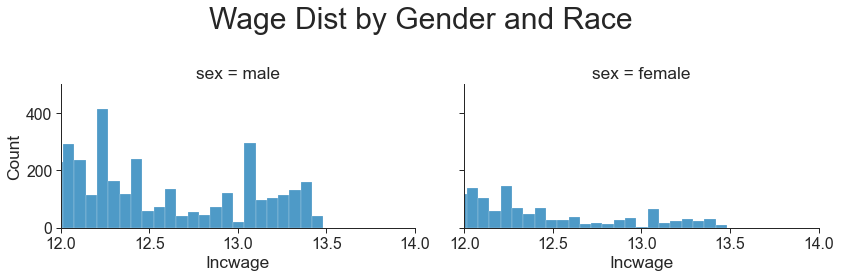

In [20]:
### Facet Grid

sns.set_theme(style="ticks")
sns.set_context("paper", font_scale=1.8)

col = sns.color_palette("PuBu")[4] 

g = sns.displot(
    vis_df, x="lnincwage", col="sex"
    , height=4, aspect=1.5 , facet_kws=dict(margin_titles=True), legend=False, log_scale=False, color=col
)


g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Wage Dist by Gender and Race', fontsize=30)

g.set_axis_labels("Incwage", "Count")
g.set_titles("Sex = Male, Sex = Female")

plt.xlim(12, 14)
plt.ylim(0,500)

g.tight_layout()

Text(0.5, 0.98, 'Wage Dist by Gender')

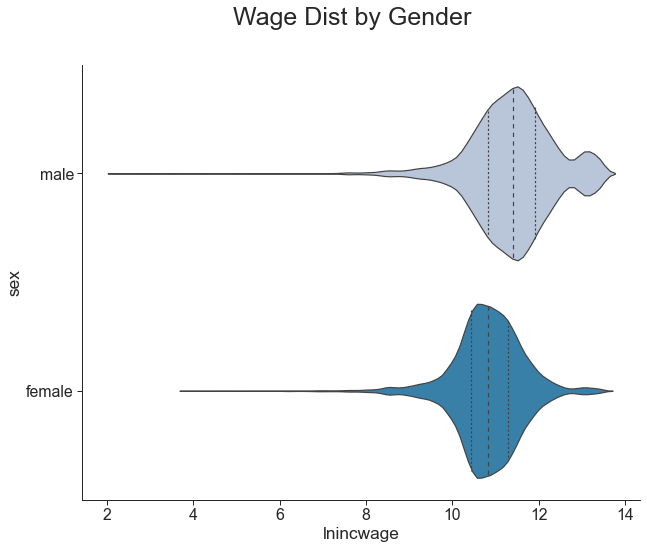

In [21]:
### Violin Plot

f, ax = plt.subplots(figsize=(10, 8))
sns.despine(f)

ax = sns.violinplot(data=vis_df, x = 'lnincwage' ,y= 'sex' ,palette="PuBu", orient="h", split=True , inner='quartiles',scale='width')
f.suptitle('Wage Dist by Gender', fontsize=25)

<AxesSubplot:xlabel='lnincwage', ylabel='Density'>

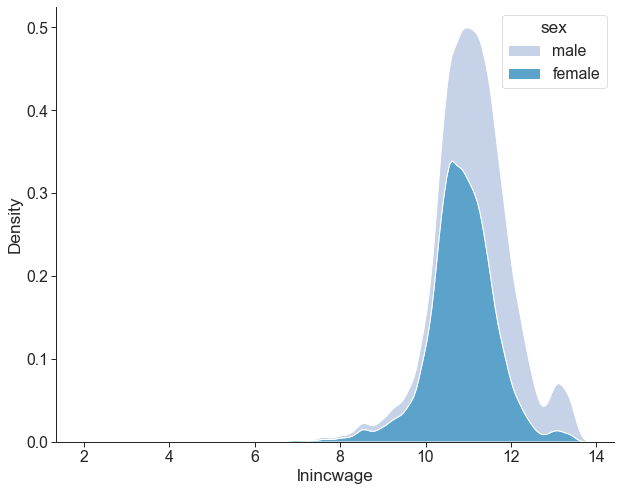

In [22]:
f, ax = plt.subplots(figsize=(10, 8))
sns.despine(f)

sns.kdeplot(data=vis_df,x='lnincwage',hue='sex',multiple='stack',palette='PuBu',linewidth=1)

# Regression for Fin_Ins 

In [23]:
fin_reg_df = reg_df[reg_df['fin_ins'] == 1]

higher_fin_reg = fin_reg_df.copy()

fin_reg_ind_var = industry_variables[:-1]

fin_reg_df = fin_reg_df.drop(fin_reg_ind_var,axis=1)

In [24]:
fin_base_group = ['white','male','college_degree','married']

drop_cols = fin_base_group + ['lnincwage']

fin_regression_cols = []
for i in fin_reg_df.columns:
    if i in drop_cols:
        continue
    else:
        fin_regression_cols.append(i)

In [25]:
y_fin = fin_reg_df['lnincwage'].to_numpy()
x_fin = sm.add_constant(fin_reg_df[fin_regression_cols].to_numpy())

In [26]:
fin_model = sm.OLS(y_fin,x_fin)
fin_model_results = fin_model.fit()

print(fin_model_results.get_robustcov_results(cov_type = 'HC1').summary(xname=['const'] + fin_regression_cols,yname='lnincwage'))

                            OLS Regression Results                            
Dep. Variable:              lnincwage   R-squared:                       0.339
Model:                            OLS   Adj. R-squared:                  0.339
Method:                 Least Squares   F-statistic:                     1133.
Date:                Mon, 07 Jun 2021   Prob (F-statistic):               0.00
Time:                        17:20:59   Log-Likelihood:                -37405.
No. Observations:               33121   AIC:                         7.484e+04
Df Residuals:                   33106   BIC:                         7.497e+04
Df Model:                          14                                         
Covariance Type:                  HC1                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               8.7107      0.063    1

Shapiro Test
stat: 0.9438318610191345
p: 0.0

Normal Test
stat: 7400.900028189973
p: 0.0


/Users/nicholasoxenden/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


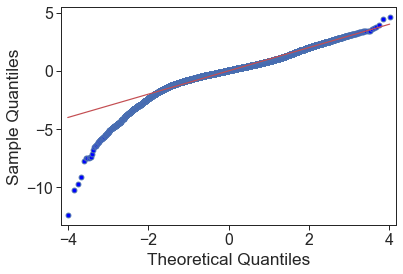

In [27]:
### Test Residuals for Normality
print("Shapiro Test")
stat, p = st.shapiro(fin_model_results.resid)
print(f"stat: {stat}")
print(f"p: {p}")
print("")
print("Normal Test")
stat, p = st.normaltest(fin_model_results.resid)
print(f"stat: {stat}")
print(f"p: {p}")

fig = smg.gofplots.qqplot(fin_model_results.resid, st.norm, fit=True, line="s")
plt.show()

In [28]:
# ### Test for heteroskedasticity
print(sm.stats.diagnostic.het_breuschpagan(fin_model_results.resid,x_fin))

# Limited Fin Reg

In [29]:
outlier_df = higher_fin_reg.copy()

In [30]:
### Keep nonoutliers
# outlier_df = outlier_df[np.abs(st.zscore(outlier_df['lnincwage'])) < st.norm.ppf(.95)]

### Keep outliers
outlier_df = outlier_df[(st.zscore(outlier_df['lnincwage'])) >= st.norm.ppf(.90)]

In [31]:
lim_fin_df = outlier_df.copy()

lim_fin_df.dropna(inplace=True)

In [32]:
lim_fin_reg_ind_var = industry_variables[:-1]

lim_fin_base_group = ['white','male','college_degree','married']

drop_cols = lim_fin_base_group + ['lnincwage'] + lim_fin_reg_ind_var + ['no_schooling'] 

lim_fin_regression_cols = []
for i in lim_fin_df.columns:
    if i in drop_cols:
        continue
    else:
        lim_fin_regression_cols.append(i)

In [33]:
y_lim = lim_fin_df['lnincwage'].to_numpy()

x_lim = sm.add_constant(lim_fin_df[lim_fin_regression_cols].to_numpy())

In [34]:
lim_model = sm.OLS(y_lim,x_lim)

lim_results = lim_model.fit()

print(lim_results.get_robustcov_results(cov_type= "HC1").summary(xname=['const'] + lim_fin_regression_cols))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     117.5
Date:                Mon, 07 Jun 2021   Prob (F-statistic):          7.97e-251
Time:                        17:20:59   Log-Likelihood:                -1207.0
No. Observations:                2688   AIC:                             2442.
Df Residuals:                    2674   BIC:                             2525.
Df Model:                          13                                         
Covariance Type:                  HC1                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              12.7735      0.185     

[None, None]

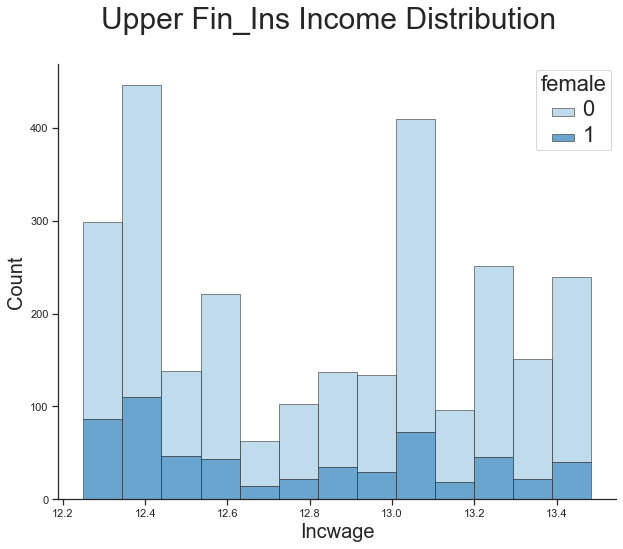

In [35]:
sns.set_theme(style="ticks")

f, ax = plt.subplots(figsize=(10, 8))
sns.despine(f)

sns.histplot(
    lim_fin_df,
    x="lnincwage", 
    hue='female',
    multiple="stack",
    palette="Blues",
    edgecolor=".1",
    linewidth=.5,
    log_scale=False,
)


f.suptitle('Upper Fin_Ins Income Distribution', fontsize=30)
ax.set_xlabel('Incwage', fontsize=20)
ax.set_ylabel('Count', fontsize=20)

plt.setp(ax.get_legend().get_texts(), fontsize='22') 
plt.setp(ax.get_legend().get_title(), fontsize='22')

#plt.ylim(0, 5000)
#plt.xlim(0, None)

Shapiro Test
stat: 0.9382282495498657
p: 4.5343001871104557e-32

Normal Test
stat: 159622.9571371907
p: 0.0


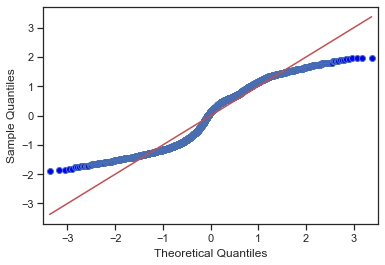

In [36]:
### Test Residuals for Normality
print("Shapiro Test")
stat, p = st.shapiro(lim_results.resid)
print(f"stat: {stat}")
print(f"p: {p}")
print("")
print("Normal Test")
stat, p = st.normaltest(lim_results.resid)
print(f"stat: {stat}")
print(f"p: {p}")

fig = smg.gofplots.qqplot(lim_results.resid, st.norm, fit=True, line="s")
plt.show()

# Resources

In [37]:
### How to get cols in a STATA friendly format
print(*lim_fin_regression_cols)

nchild age agesq nchildsq unmarried female black asian other_race elementary_educ hs_educ partial_college grad_educ


In [38]:
### Use to send df to STATA
# lim_fin_df.to_stata("/Users/nicholasoxenden/Oxenden/ECON 388/388 Paper/388 Research Data/IPUMS/high_wage.dta")

In [39]:
### Use to save sm output
# plt.rc('figure', figsize=(12, 7))
# #plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 12}) old approach
# plt.text(0.01, 0.05, str(lim_results.get_robustcov_results(cov_type = 'HC1').summary(xname=['const'] + fin_regression_cols,yname='lnincwage')), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
# plt.axis('off')
# plt.tight_layout()
# plt.savefig('sm_output_rough_draft1.png')